This exercies has an implementation on an arbitrary length network defined by you the user. This network was written for 
$$ Y = w_n(cos(w_{n-1}*z_{n-1})) $$
Where $$ z_{n-1} = (cos(w_{n-2}*z_{n-2})) $$
starting with $z_0$
This first block just initiallizes some random weights to train both the residual and nonresidual network.

In [15]:
import numpy as np

X = 3.  #Mapping X = input to Y = output
Y = 6.

numnodes = 50 # Sets the number of layers, this includes the input and output

eta = 1.0e-4 #set stepsize for later grad descent

nodeval = np.random.rand(numnodes) #initialize the node values with the first node as the input
nodeval[0] = X

weights = np.random.rand(numnodes-1) #initializes weights, and gradients, and bias
nodegrad = np.random.rand(numnodes-1)
bias = np.random.rand(numnodes-1)

nodeval_1 = nodeval + 0 #There will be two tests, one with a plain network here
weights_1 = weights + 0
nodegrad_1 = nodegrad + 0
bias_1 = nodegrad + 0 

nodeval_res = nodeval + 0 #This will be for the resnet 
weights_res = weights + 0
nodegrad_res = nodegrad + 0
bias_res = bias + 0 

This defines forward and backward modes for these derivatives. I'm about 80 percent sure this is right.

In [16]:
def forward(nodes, weights, bias): #define forward mode for the plain network

    for i in range(len(nodes)-2):
        #each layer is defined of the previous output times a weight plus a bias
        nodenext = np.sin(weights[i]*nodes[i]+bias[i])
        nodes[i+1] = nodenext
    
        grad = np.cos(weights[i]*nodes[i]+bias[i])*weights[i] #The gradient of each layer wrt the input
        nodegrad[i+1] = grad
    
    nodes[-1] = weights[-1]*nodes[-2] + bias[-1] #set the last node with a linear transformation
    nodegrad[-1] = weights[-1] #set that gradient wrt to input
    
    return nodes, nodegrad


def backward(nodes, weights, bias, nodegrad, seed): #define backward mode
    
    gradientw = [] #save each weight and bias gradients
    gradientb = []
    
    gradienttot = seed #seed is defined by the loss function, squared difference in this case
    gradientw.append(gradienttot*nodes[-2]) #save the gradient wrt to first weight
    gradientb.append(gradienttot)
    
    for i in range(len(nodegrad)-1):
        gradienttot *= nodegrad[-(i+2)] #backpropogate 
        gradientw.append(gradienttot*nodes[-(3+i)]*np.cos(nodes[-(3+i)]*weights[-(2+i)]+bias[-(2+i)]))
        gradientb.append(gradienttot*np.cos(nodes[-(3+i)]*weights[-(2+i)]+bias[-(2+i)]))
        
    gradientw = np.array(gradientw) #convert to arrays
    gradientb = np.array(gradientb)
    
    return gradientw[::-1], gradientb[::-1] #flip because I appended the output gradient first

def dL(out, target): #define loss function
    L = (out - target)**2
    dL = 2*(out - target)
    return L, dL

In [17]:
for i in range(100000): #Train the network for a bunch of epochs
    nodeval_1, nodegrad_1 = forward(nodeval_1, weights_1, bias_1)
    
    loss, lossgrad = dL(nodeval_1[-1], Y)
    
    gradientsw, gradientsb = backward(nodeval_1, weights_1, bias_1, nodegrad_1, lossgrad)
    
    weights_1 -= gradientsw*eta
    bias_1 -= gradientsb*eta
    
    if i%10000 == 0:
        print(loss)

nodeval_1, nodegrad_1 = forward(nodeval_1, weights_1, bias_1) #compute final guess

print('Target = ', Y, ' Guess = ', nodeval_1[-1]) #See how well we did
    

21.43028140635458
0.006444483290424556
2.1130441959557825e-06
6.932870026826189e-10
2.2746918843647854e-13
7.463335999766456e-17
2.4486319115386765e-20
8.632397600750422e-24
1.232595164407831e-24
1.232595164407831e-24
Target =  6.0  Guess =  5.99999999999889


Well, that isn't the best. Let's try a residual implementation where $$ Y = w_n(cos(w_{n-1}*z_{n-1})) + z_{n-1}$$
Where $$ z_{n-1} = (cos(w_{n-2}*z_{n-2})) + z_{n-2} $$
starting with $z_0$

In [18]:
def forward_res(nodes, weights, bias): #same architecture but with skip connections

    for i in range(len(nodes)-2):
        nodenext = np.sin(weights[i]*nodes[i]+bias[i]) + nodes[i] #here the input is added
        nodes[i+1] = nodenext
    
        grad = np.cos(weights[i]*nodes[i])*weights[i] + 1 #derivative wrt to the input is 1 so that is added
        nodegrad[i+1] = grad
    
    nodes[-1] = weights[-1]*nodes[-2] + nodes[-2] + bias[-1]
    nodegrad[-1] = weights[-1] + 1
    
    
    return nodes, nodegrad


def backward_res(nodes, weights, bias, nodegrad, seed): #backpropogate this function is the same in both modes
    
    gradientw = []
    gradientb = []
    
    gradienttot = seed
    gradientw.append(gradienttot*nodes[-2])
    gradientb.append(gradienttot)
    
    for i in range(len(nodegrad)-1):
        gradienttot *= nodegrad[-(i+2)]
        gradientw.append(gradienttot*nodes[-(3+i)]*np.cos(nodes[-(3+i)]*weights[-(2+i)]+bias[-(2+i)]))
        gradientb.append(gradienttot*np.cos(nodes[-(3+i)]*weights[-(2+i)]+bias[-(2+i)]))
        
    gradientw = np.array(gradientw)
    gradientb = np.array(gradientb)
    
    return gradientw[::-1], gradientb[::-1]


In [19]:
for i in range(100000): #train the network
    nodeval_res, nodegrad_res = forward_res(nodeval_res, weights_res, bias_res)
    
    loss, lossgrad = dL(nodeval_res[-1], Y)

    gradientsw, gradientsb = backward_res(nodeval_res, weights_res, bias_res, nodegrad_res, lossgrad)
    
    weights_res -= gradientsw*eta
    bias_res -= gradientsb*eta
    
    if i%10000 == 0:
        print(loss)
        
nodeval_res, nodegrad_res = forward_res(nodeval_res, weights_res, bias_res) #compute final answer
print('Target = ', Y, ' Guess = ', nodeval_res[-1]) #see how we did

52.50191573055269
1.4586038137536508e-27
1.4586038137536508e-27
1.4586038137536508e-27
1.4586038137536508e-27
1.4586038137536508e-27
1.4586038137536508e-27
1.4586038137536508e-27
1.4586038137536508e-27
1.4586038137536508e-27
Target =  6.0  Guess =  6.000000000000038


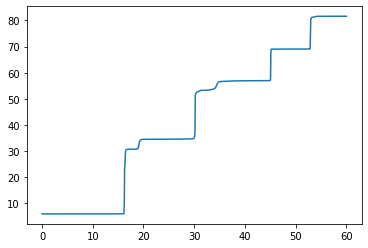

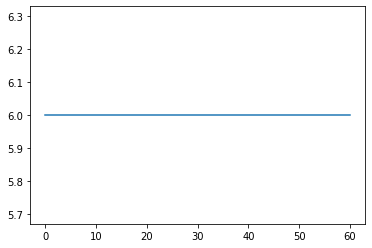

In [23]:
import matplotlib.pyplot as plt
check = np.linspace(0, 60, 1000) #Plots the output functions as a function of the input, you can see how the
#mappings change
empty = np.zeros(numnodes)
values = []

for i in check:
    empty[0] = i
    n, g = forward_res(empty, weights_res, bias_res)
    values.append(n[-1])

plt.plot(check, values)

values = []

for i in check:
    empty[0] = i
    n, g = forward(empty, weights_1, bias_1)
    values.append(n[-1])


plt.figure()
plt.plot(check, values)
plt.show()

Assuming, I implemented this correctly, just increadible. It is interesting to node that the plain network tries to supress the sin, and just move with the bias, where the residual mapping, has a sort of step function to work with, and converges a lot faster.

I was trying to get this to work with T-money's autodiff, but was failing. It would be more general and fun if we can get it working. 

In [1]:
import numpy as np

class Constant:
    
    def __init__(self, a):
        # Initialize the value of this variable with the value passed in
        self.a_value = a
        # to make sure our children don't throw an exception when they access our grad variable 
        # as in backward() in the BinaryAdd()
        self.grad = 0
    
    def forward(self):
        # what should this return?
        # TODO: fill in the return value
        # Remember this is the last node of the graph.
        return self.a_value
    
    def backward(self):
        # What should go here if it's a constant?
        # Nothing. We want the backpropagation to stop here. 
        # In python, we use pass as shorthand for "return None".
        # Doing this means we can inject constants at any point in the computational graph.
        pass

class BinaryAdd:
    
    def __init__(self, a, b):
        # record the two parents of the binary add
        self.a = a
        self.b = b
        # and initialize the gradient to 0.
        self.grad = 0
        
    def forward(self):
        # a _value and b_value
        # are intermediate values in the computational graph
        # like v4 in Table 3 in the paper.
        # We don't have to store the value of a or b, 
        # but caching them now means we don't have to recompute them on the backward pass.
        self.a_value = self.a.forward()
        self.b_value = self.b.forward()
        return self.a_value + self.b_value
    
    def backward(self):
        # z = a + b
        # dz/da = ?
        # TODO: fill in the None values.
        # Remember, a and b are the parents of this object. 
        dzda = 1
        dzdb = 1
        self.a.grad += dzda*self.grad
        self.b.grad += dzdb*self.grad

class BinaryMul:
    
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.grad = 0
        # TODO: what's missing? What other value do we have to store in a node?
        
    
    def forward(self):
        # again, we don't have to cache self.a_value or self.b_value
        # but it makes the backward pass not have to call a.forward() or b.forward()
        # TODO: fill in None
        self.a_value = self.a.forward()
        self.b_value = self.b.forward()
        return self.a_value * self.b_value

    def backward(self):
        # TODO: fill in the gradient values below (dzda, dzdb)
        # z = a*b 
        # dz/da = ?
        dzda = self.b_value
        dzdb = self.a_value
        self.a.grad += dzda*self.grad
        self.b.grad += dzdb*self.grad
        
class Ln:
    
    def __init__(self, a):
        self.a = a
        self.grad = 0

    def forward(self):
        # TODO: fill me in
        self.a_value = self.a.forward()
        return np.log(self.a_value)
    
    def backward(self):
        # TODO: fill me in
        # z = ln(a)
        # dz/da = ?
        self.a.grad += 1/self.a_value*self.grad

        
class Sin:
    
    def __init__(self, a):
        self.a = a
        self.grad = 0
        
    def forward(self):
        # TODO: fill me in
        self.a_value = self.a.forward()
        return np.sin(self.a_value)
    
    def backward(self):
        # TODO: fill me in 
        # z = sin(a)
        # dz/da = ?
        self.a.grad += np.cos(self.a_value)*self.grad


class BinarySub:
    
    def __init__(self, a, b):
        # TODO:
        # record the two parents of the binary subtract
        self.a = a
        self.b = b
        # and initialize the gradient to 0.
        self.grad = 0
        
    def forward(self):
        # TODO: How do I get a and b?
        self.a_value = self.a.forward()
        self.b_value = self.b.forward()
        return self.a_value - self.b_value
    
    def backward(self):
        # z = a - b
        # dz/da = ?
        # TODO: fill in the None values.
        # Remember, a and b are the parents of this object. 
        dzda = 1
        dzdb = -1
        self.a.grad += dzda*self.grad
        self.b.grad += dzdb*self.grad  # Why is this a += operator?

In [7]:
X = Constant(3)
Y = 2.

w1 = Constant(.4)
w2 = Constant(.1)

v1 = BinaryMul(X, w1)
v2 = Sin(v1)
v3 = BinaryMul(v2, w2)

eta = 1.0e-5

for i in range(100000):

    y = v3.forward()
    
    #print('y: {}'.format(y))
    #print(.5*np.sin(.4*4))

    # TODO: seed the gradient value
    v3.grad = 2*(y - Y) 
    v3.backward()

    # Instead of calling backward() on each node by hand, put the nodes in 
    # a list and iterate over it backwards.

    ls = [X, w1, v1, v2, w2]

    for node in ls[::-1]:
        #print(node.grad)
        node.backward()
    
    w1.a_value -= w1.grad*eta
    w2.a_value -= w2.grad*eta

print('y: {}'.format(y))


y: -0.9785235488295365


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
np.random.seed(0)

In [2]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=100,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [3]:
class Net(nn.Module):
    def __init__(self,layers, input_size, num_class):
        super(Net, self).__init__()
        self.input = input_size
        self.classes = num_class
        self.layers = layers
        self.linears = nn.ModuleList([nn.Linear(self.input,self.input)])
        self.linears.extend([nn.Linear(self.input, self.input) for i in range(1, self.layers-1)])
        self.linears.append(nn.Linear(self.input, self.classes))
        
    def forward(self, x):
        temp = None
        i = 0
        for layer in self.linears:
            if i%3 == 0:
                x = torch.sigmoid(layer(x))
                i += 1
            else:
                x = layer(x)
                i += 1

        return x

In [4]:
input_size = 784       # The image size = 28 x 28 = 784
num_classes = 10       # The number of output classes. In this case, from 0 to 9
num_epochs = 10         # The number of times entire dataset is trained
batch_size = 100       # The size of input data took for one iteration
learning_rate = 1e-3  # The speed of convergence
net = Net(10, input_size,num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn.ParameterList(net.parameters()), lr=learning_rate)

In [5]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        images = Variable(images.view(-1,28*28))         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = Variable(labels)
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(images)                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()
    total=0
    correct=0
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = net(d.view(-1,28*28))
        _, predicted = torch.max(outputs.data,1)
        total += Variable(t).size(0)
        correct += (predicted==t).sum()
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),(100.*correct/total).item())

0 2.3143715858459473 10.279999732971191
1 2.302456855773926 11.350000381469727
2 2.3005683422088623 11.350000381469727
3 2.2983646392822266 11.350000381469727
4 2.2984426021575928 11.350000381469727
5 2.316406726837158 11.350000381469727
6 2.3070859909057617 11.350000381469727
7 2.293673038482666 11.350000381469727
8 2.3094537258148193 10.279999732971191
9 2.2959601879119873 11.350000381469727


In [23]:
class resNet(nn.Module):
    def __init__(self,layers, input_size, num_class):
        super(resNet, self).__init__()
        self.input = input_size
        self.classes = num_class
        self.layers = layers
        self.linears = nn.ModuleList([nn.Linear(self.input,self.input)])
        self.linears.extend([nn.Linear(self.input, self.input) for i in range(1, self.layers-1)])
        self.linears.append(nn.Linear(self.input, self.classes))
    def forward(self, x):
        temp = x
        i = 0
        for layer in self.linears:
            print(layer(x))
            if i%3 == 0:
                x = torch.sigmoid(layer(x))
                i += 1
            else:
                x = layer(x)
                i += 1
        print(x.shape, temp.shape)
        return x + temp 

In [24]:
input_size = 784       # The image size = 28 x 28 = 784
num_classes = 10       # The number of output classes. In this case, from 0 to 9
num_epochs = 10         # The number of times entire dataset is trained
batch_size = 100       # The size of input data took for one iteration
learning_rate = 1e-3  # The speed of convergence
resnet = resNet(10, input_size,num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn.ParameterList(net.parameters()), lr=learning_rate)

In [25]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        images = Variable(images.view(-1,28*28))         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = Variable(labels)
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = resnet(images)                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()
    total=0
    correct=0
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = net(d.view(-1,28*28))
        _, predicted = torch.max(outputs.data,1)
        total += Variable(t).size(0)
        correct += (predicted==t).sum()
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),(100.*correct/total).item())

tensor([[-0.0603, -0.2374, -0.2596,  ..., -0.0049, -0.0785,  0.1213],
        [ 0.0942,  0.3139,  0.1319,  ...,  0.0852,  0.2276,  0.1503],
        [-0.1532,  0.4307,  0.0131,  ...,  0.1803,  0.0502,  0.3117],
        ...,
        [ 0.2572,  0.1046, -0.0641,  ..., -0.0265,  0.0656,  0.1438],
        [-0.1443, -0.0782, -0.0690,  ...,  0.2466, -0.0380, -0.2145],
        [ 0.0371,  0.3303, -0.0805,  ...,  0.1398, -0.0016,  0.3181]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.2547,  0.3964, -0.0981,  ...,  0.3998,  0.0472,  0.4862],
        [ 0.2870,  0.4213, -0.1102,  ...,  0.4171,  0.0543,  0.4647],
        [ 0.2867,  0.4680, -0.1283,  ...,  0.3914,  0.0279,  0.5167],
        ...,
        [ 0.2586,  0.4255, -0.0690,  ...,  0.4227,  0.0383,  0.4575],
        [ 0.2364,  0.4134, -0.1002,  ...,  0.3563,  0.0842,  0.4902],
        [ 0.2969,  0.4835, -0.1125,  ...,  0.4052,  0.0309,  0.4820]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.2523,  0.4345,  0.0059,  ..., -0.1859, -0.0016, -0.1131]

RuntimeError: The size of tensor a (10) must match the size of tensor b (784) at non-singleton dimension 1